# MDA + RBF (Aveiro Waves)

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from bluemath_tk.datamining.mda import MDA
from bluemath_tk.datamining.lhs import LHS
from bluemath_tk.interpolation.rbf import RBF

from utils.plotting import plot_variable_combinations
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Load Dataset

In [2]:
data = (
    xr.open_dataset("/workspaces/BlueMath/climate_services/MUSCLE.Aveiro/data/era5_aveiro.nc")
    .rename({"swh": "Hs", "pp1d": "Tp", "mwd": "Dir"})
    .to_dataframe()
    .iloc[::10, :]
    .reset_index()
    .drop(columns=["latitude", "longitude", "time"])
)
data

,Hs,Tp,Dir
0,4.233710,7.783655,170.643792
1,3.931029,13.985347,214.811325
2,4.210661,13.922741,233.840720
3,4.045769,14.130647,243.036796
4,3.583768,13.645868,250.315649
...,...,...,...
73630,2.037433,11.260138,297.323308
73631,1.970565,11.130574,296.636624
73632,2.304654,11.563795,287.248277
73633,4.109092,13.685708,308.639865


In [3]:
num_centers = 100
dir_vars = ['Dir']

mda = MDA(num_centers=num_centers)
nearest_centroids_idxs, nearest_centroids_df = mda.fit_predict(
    data=data,
    directional_variables=dir_vars,
)

2025-04-02 10:34:11,621 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


/workspaces/BlueMath/toolkit/datamining/utils/plotting.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(v1, v2, c=data_color, s=size_point, cmap  = 'rainbow', alpha=0.2)


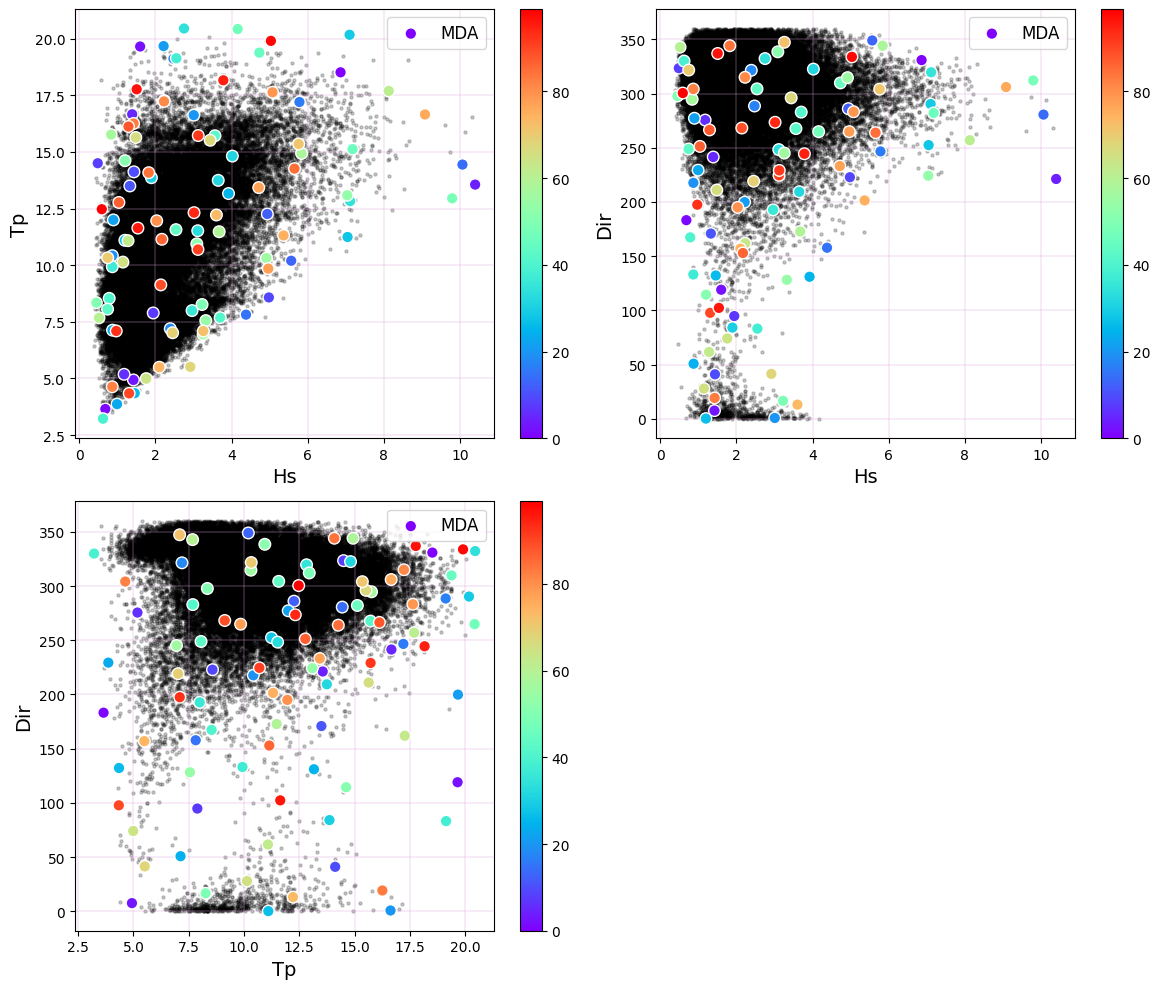

In [4]:
vars = ['Hs', 'Tp', 'Dir']  # Lista de variables
sel_mda = mda.centroids[vars]  # Selección de puntos
plot_variable_combinations(mda.data, vars, mda.centroids, labels = 'MDA')

# MDA + RBF

The energy flux EF, depends on the variables Hs and Tp, and can be computed follwing: EF = Hs**2 * Tp

In [5]:
target = pd.DataFrame(
    {
        "EF": mda.centroids.Hs.values**2 * mda.centroids.Tp.values,
    }
)

/workspaces/BlueMath/toolkit/datamining/utils/plotting.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(v1, v2, c=data_color, s=size_point, cmap  = 'rainbow', alpha=0.2)


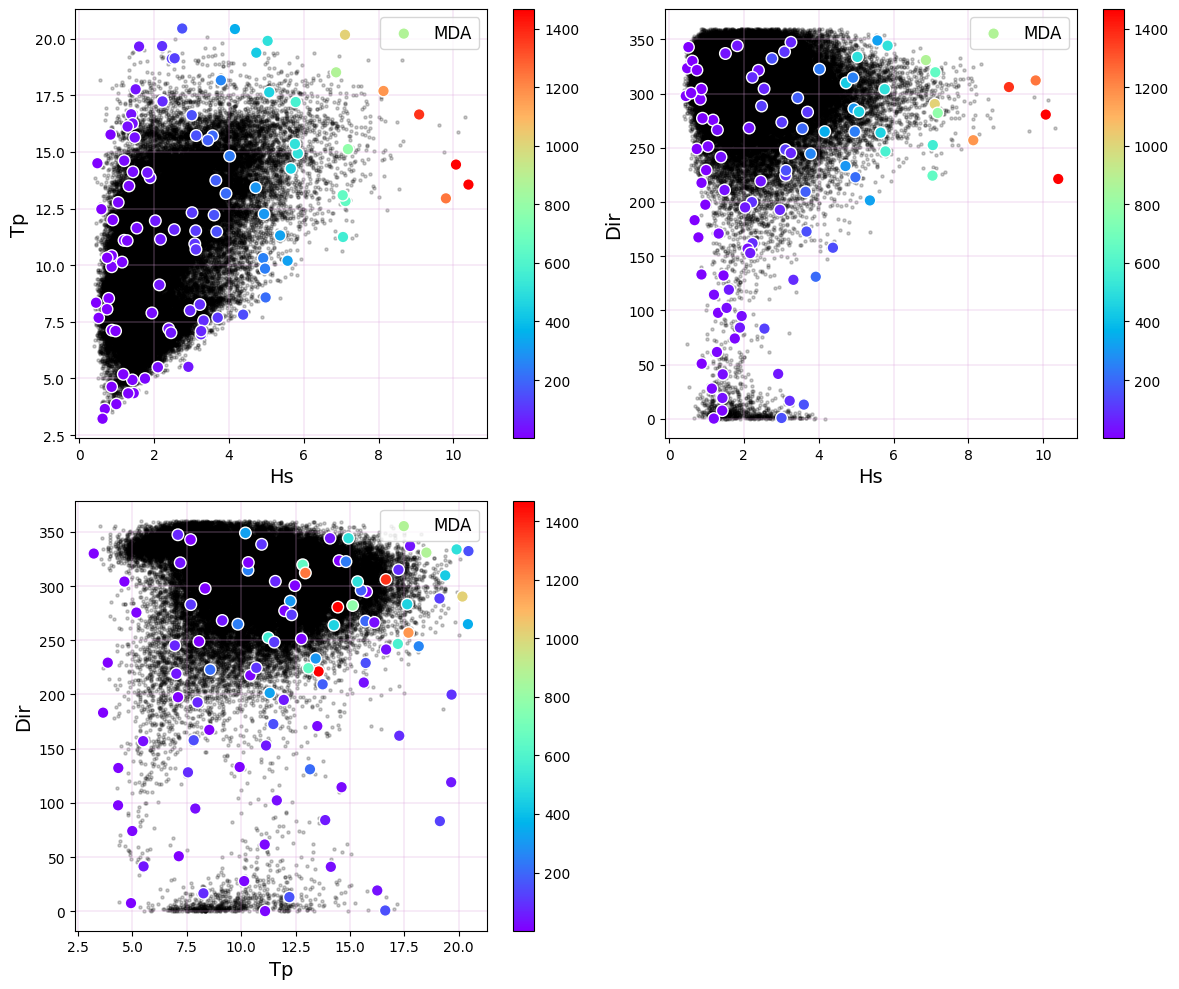

In [6]:
vars = ['Hs', 'Tp', 'Dir']  # Lista de variables
sel_mda = mda.centroids[vars]  # Selección de puntos
plot_variable_combinations(mda.data, vars, mda.centroids, sel_color = target.EF, labels = 'MDA')

## RBF

In [7]:
dataset = data # Data to interpolate
 
subset = mda.centroids # Parameters to fit RBF
target = target # Response to fit RBF

subset_directional_variables = ['Dir']
target_directional_variables = []

In [8]:
rbf = RBF()

predictions = rbf.fit_predict(
    subset_data=subset,
    subset_directional_variables=subset_directional_variables,
    target_data=target,
    target_directional_variables=target_directional_variables,
    normalize_target_data=True,
    dataset=dataset,
    num_workers=4,
    iteratively_update_sigma=True,
)
print(predictions.head())

2025-04-02 10:34:31,040 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-04-02 10:34:31,696 - RBF - WARNING - Proposed min custom scaler for Hs is bigger than datapoint
2025-04-02 10:34:31,702 - RBF - WARNING - Proposed min custom scaler for Dir_u is bigger than datapoint
2025-04-02 10:34:31,703 - RBF - WARNING - Proposed max custom scaler for Dir_u is lower than datapoint
2025-04-02 10:34:31,704 - RBF - WARNING - Proposed min custom scaler for Dir_v is bigger than datapoint
2025-04-02 10:34:31,705 - RBF - WARNING - Proposed max custom scaler for Dir_v is lower than datapoint


           EF
0  143.862896
1  216.119486
2  247.293456
3  232.852770
4  176.582442


In [9]:
predictions

,EF
0,143.862896
1,216.119486
2,247.293456
3,232.852770
4,176.582442
...,...
73630,45.869992
73631,42.335707
73632,59.451181
73633,233.246836


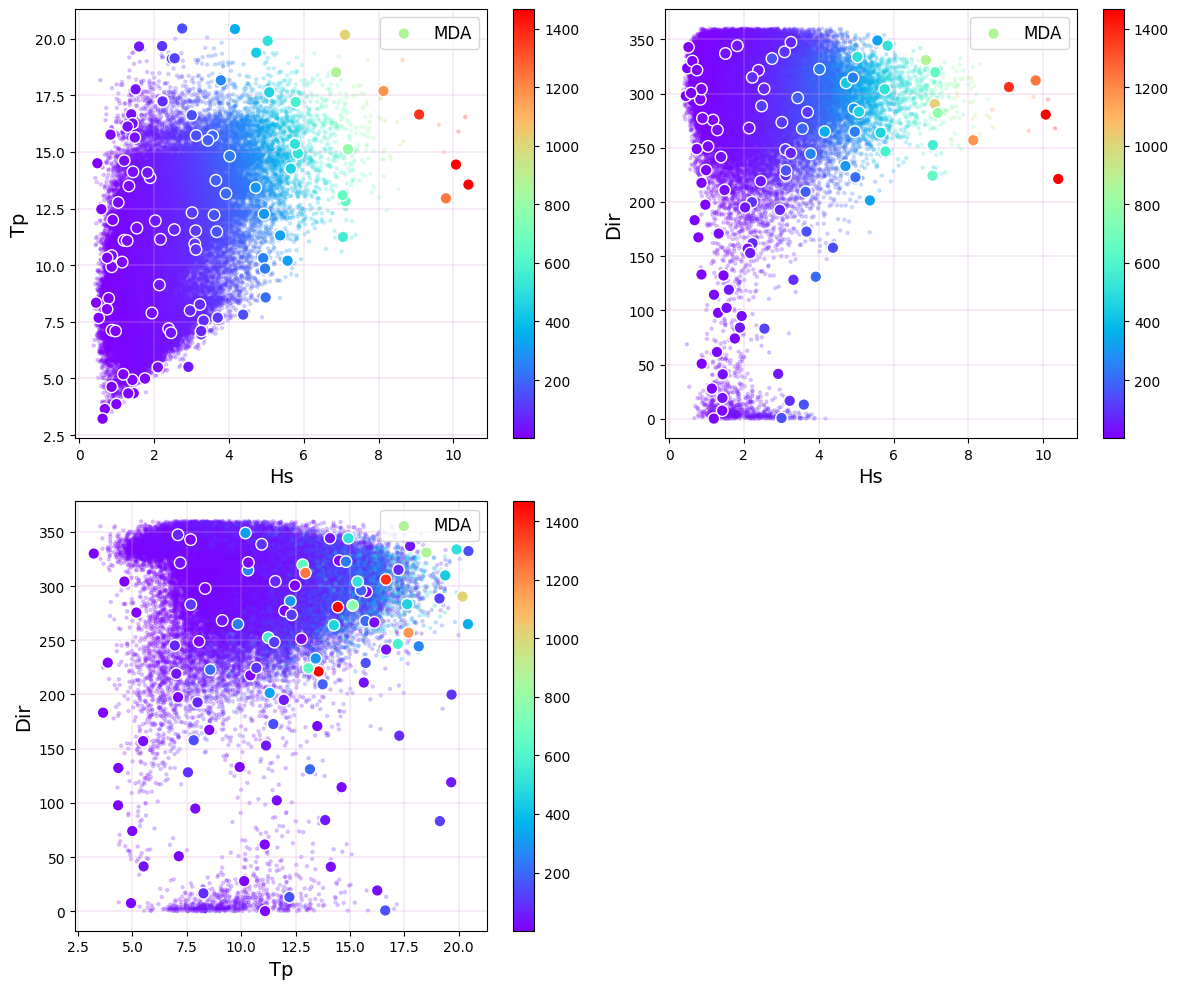

In [10]:
vars = ['Hs', 'Tp', 'Dir']  # Lista de variables
sel_mda = mda.centroids[vars]  # Selección de puntos
plot_variable_combinations(mda.data, vars, mda.centroids, data_color = predictions.EF, sel_color = target.EF, labels = 'MDA')

## 14. Root Mean Square Error

$$\textbf{RMSE =  } sqrt(\frac{\sum(RBF_{model} - Real)^2}{n})$$


In [11]:
RMSE = np.sqrt(np.mean((predictions.EF - (data.Hs**2*data.Tp))**2))
RMSE

np.float64(2.1086286176185336)

## 15. Optimal number of points

- Seleccionar 50 valores entre 50 y 500

In [12]:
num_centers_explore = np.arange(10, 600, 50)

In [13]:
RMSE = []
rbf = RBF()
rbf.set_logger_name(name="RBF-file", level="WARN", console=False)

for d in num_centers_explore:
    
    # MDA
    dir_vars = ['Dir']

    mda = MDA(num_centers=d)
    nearest_centroids_idxs, nearest_centroids_df = mda.fit_predict(
        data=data,
        directional_variables=dir_vars,
    )

    target = pd.DataFrame(
        {
            "EF": mda.centroids.Hs.values**2 * mda.centroids.Tp.values,
        }
    )

    # RBF
    
    subset = mda.centroids # Parameters to fit RBF
    target = target # Response to fit RBF

    predictions = rbf.fit_predict(
        subset_data=subset,
        subset_directional_variables=subset_directional_variables,
        target_data=target,
        target_directional_variables=target_directional_variables,
        normalize_target_data=True,
        dataset=dataset,
        num_workers=4,
        iteratively_update_sigma=True,
    )

    RMSE.append(np.sqrt(np.mean((predictions.EF - (data.Hs**2*data.Tp))**2)))

2025-04-02 10:34:49,614 - RBF - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-04-02 10:34:49,618 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.



        ---------------------------------------------------------------------------------
        | Initializing RBF interpolation model with the following parameters:
        |    - sigma_min: 0.001
        |    - sigma_max: 0.1
        |    - sigma_diff: 0.0001
        |    - sigma_opt: None
        |    - kernel: gaussian
        |    - smooth: 1e-05
        | For more information, please refer to the documentation.
        | Recommended lecture: https://link.springer.com/article/10.1023/A:1018975909870
        ---------------------------------------------------------------------------------
        


2025-04-02 10:35:06,913 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-04-02 10:35:24,496 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-04-02 10:35:42,723 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-04-02 10:36:02,062 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-04-02 10:36:22,723 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-04-02 10:36:43,885 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-04-02 10:37:06,135 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-04-02 10:37:30,738 - MDA - WARNING - Setting self.num_workers to 1. Change it using self.set_num_pr

Text(0, 0.5, 'RMSE')

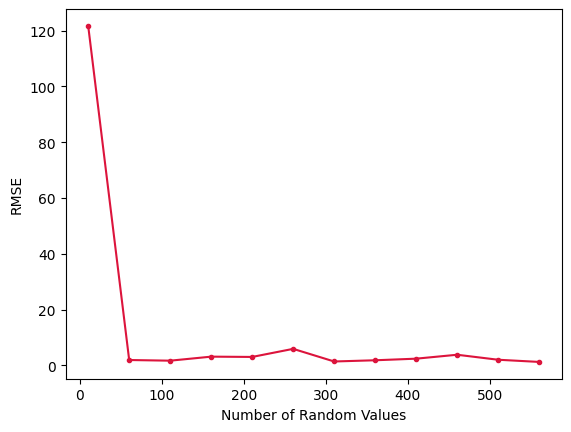

In [14]:
plt.plot(num_centers_explore, RMSE, '.-' ,color = 'crimson')
plt.xlabel('Number of Random Values')
plt.ylabel('RMSE')